In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
%run ./kp_sunspot_dataloader.ipynb

data under threshold: 4855, data over threshold: 374


In [3]:
%run ./binary_classifier.ipynb

In [4]:
# Preprocessing
df["geomagnetic_storm"] = df['Kp'] # to signify its purpose as the y value
# Select features and label
X = df[['Kp', 'solar_spots_per_day']].values
y = df['geomagnetic_storm'].values # 'geomagnetic_storm' (1 for geomagnetic storm, 0 for no geomagnetic storm)

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [7]:
# Initialize the model
input_size = X_train.shape[1]
model = BinaryClassificationModel(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Training loop
num_epochs = 1000

Epoch [10/1000], Loss: 0.3594
Epoch [20/1000], Loss: 0.3154
Epoch [30/1000], Loss: 0.2785
Epoch [40/1000], Loss: 0.2480
Epoch [50/1000], Loss: 0.2226
Epoch [60/1000], Loss: 0.2013
Epoch [70/1000], Loss: 0.1831
Epoch [80/1000], Loss: 0.1673
Epoch [90/1000], Loss: 0.1536
Epoch [100/1000], Loss: 0.1415
Epoch [110/1000], Loss: 0.1309
Epoch [120/1000], Loss: 0.1213
Epoch [130/1000], Loss: 0.1129
Epoch [140/1000], Loss: 0.1052
Epoch [150/1000], Loss: 0.0984
Epoch [160/1000], Loss: 0.0922
Epoch [170/1000], Loss: 0.0866
Epoch [180/1000], Loss: 0.0815
Epoch [190/1000], Loss: 0.0768
Epoch [200/1000], Loss: 0.0726
Epoch [210/1000], Loss: 0.0687
Epoch [220/1000], Loss: 0.0651
Epoch [230/1000], Loss: 0.0618
Epoch [240/1000], Loss: 0.0588
Epoch [250/1000], Loss: 0.0560
Epoch [260/1000], Loss: 0.0534
Epoch [270/1000], Loss: 0.0510
Epoch [280/1000], Loss: 0.0487
Epoch [290/1000], Loss: 0.0466
Epoch [300/1000], Loss: 0.0447
Epoch [310/1000], Loss: 0.0428
Epoch [320/1000], Loss: 0.0411
Epoch [330/1000],

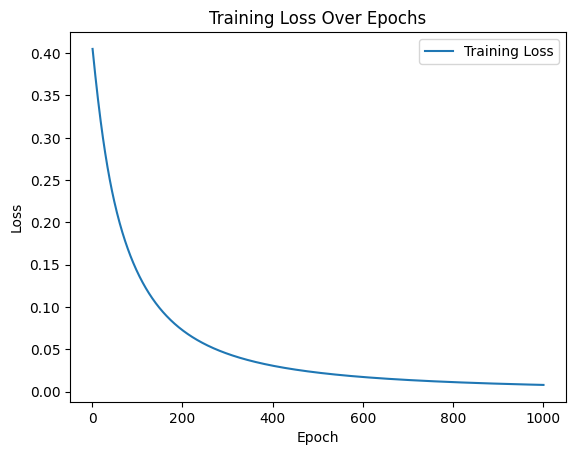

In [8]:
train_losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

Accuracy on test set: 1.00


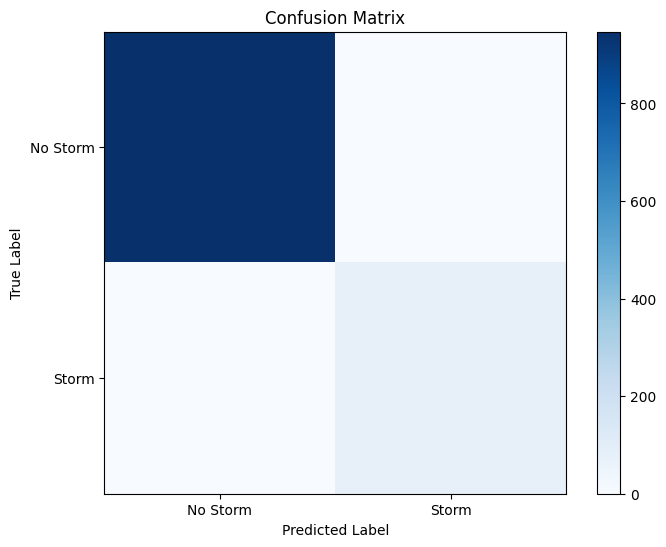

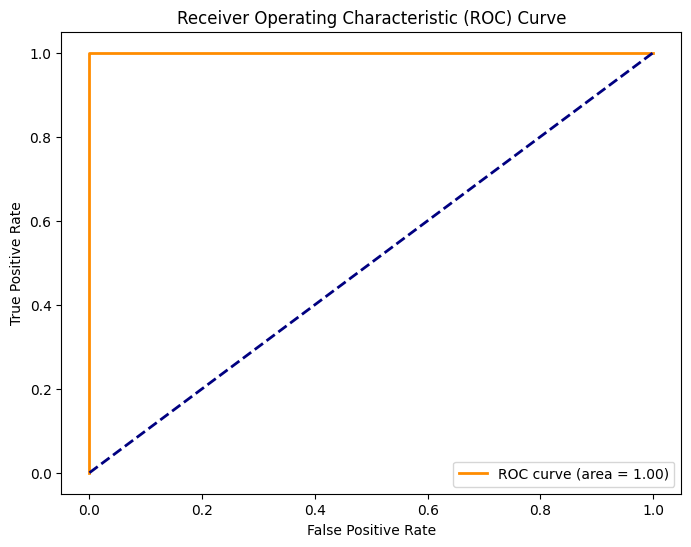

In [9]:
# Evaluation
with torch.no_grad():
    # Predictions on test set
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy on test set: {accuracy:.2f}')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, predicted)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks([0, 1], ['No Storm', 'Storm'])
    plt.yticks([0, 1], ['No Storm', 'Storm'])
    plt.show()
    
    # ROC curve / false positive and true positives
    fpr, tpr, thresholds = roc_curve(y_test, outputs.numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()